In [3]:
# I.
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np

# II
# Download reference table
w_land = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/w_land.csv')

#  wlands Backup
w_land = w_land.copy()

# III Convert the df into geopandas df
w_land['geometry'] = w_land['geometry'].apply(wkt.loads)
w_land = gpd.GeoDataFrame(w_land, geometry='geometry')


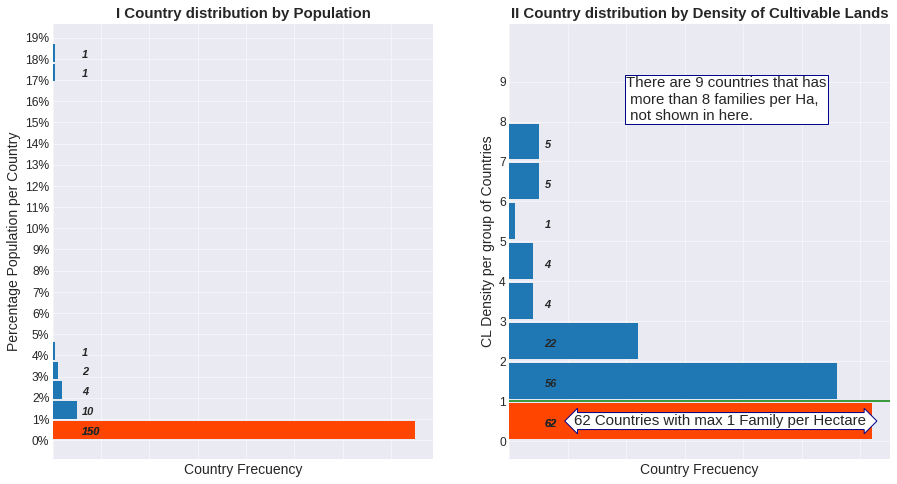

In [4]:
# VI Histogram division

%matplotlib inline

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'xtick.labelsize':12,
                     'ytick.labelsize':12,
                     'ytick.labelleft':'on',
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,
                     'axes.spines.bottom' : False,
                     'axes.spines.top': False, 
                     'axes.spines.right':False,
                     'ytick.left':False,
                     'xtick.bottom':False,
                     'xtick.top': False,
                     'axes.labelsize':14,
                     'axes.edgecolor':'slategrey',
                     'grid.linewidth':0.5
                    })


fig = plt.figure(figsize=(15,8))

#### GRAPH 1 ####
ax3 = fig.add_subplot(1,2,1)

ax3.set_ylabel('Percentage Population per Country')
ax3.set_xlabel('Country Frecuency')
ax3.set_title('I Country distribution by Population', weight='bold', size=15)

a_bins = 20
ax3, bins, patches3 = plt.hist(w_land['pop_est%'],
                               bins= a_bins, orientation='horizontal', rwidth=0.9)
patches3[0].set_fc('orangered')
plt.yticks(np.arange(0, 20, 1))

# Y axe in percentaje
fmt = '%.0f%%'
yticks = ticker.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)

# # Adding the value of each bar (plot1)
high = 0.2
def texto(x):
    texto = lambda t: plt.text(x, high + t.xy[1], int(t.get_width()),size=11, 
                           fontweight='bold', fontstyle='oblique')
    return texto

vfunc1 = np.vectorize(texto(12))

## Filter the 0 width columns (plot1)
p1 = [patches3[i] for i in range(len(patches3)) if patches3[i].get_width() > 0]
vfunc1(p1)

#### GRAPH 2 ####
ax4 = fig.add_subplot(1,2,2)

ax4.set_ylabel('CL Density per group of Countries')
ax4.set_xlabel('Country Frecuency')
ax4.set_title('II Country distribution by Density of Cultivable Lands', weight='bold', size=15)

b_bins = 10
ax4, bins, patches4 = plt.hist(w_land['density_CL'],  orientation='horizontal', bins= b_bins,
                            range= [0,10], rwidth=0.9, bottom=0) 

# Text BBoxes with notes
plt.text(11, 0.35+patches4[0].xy[1], '62 Countries with max 1 Family per Hectare', fontsize=15 ,
         bbox=dict(boxstyle='darrow,pad=0.1', fc='white', ec='darkblue'))
plt.text(20, 1+patches4[7].xy[1], 
         'There are 9 countries that has\n more than 8 families per Ha,\n not shown in here.', fontsize=15 ,
         bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='darkblue'))

# # Adding the value of each bar (plot2)
high = 0.3
p2 = [patches4[i] for i in range(len(patches4)) if patches4[i].get_width() > 0]

vfunc2 = np.vectorize(texto(6))
vfunc2(p2)

# # Aditional styling
plt.axhline(y=1, color='green') # Adding the reference line
plt.yticks(np.arange(0, 10, 1)) # Changing the y steps
patches4[0].set_fc('orangered')

plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/hist_dens.png')

plt.show()
